In [ ]:
# Install libraries
# https://docs.tweepy.org/en/stable/index.html
# https://pypi.org/project/deep-translator/
# https://github.com/bsolomon1124/demoji
# https://pypi.org/project/textblob/
# https://pypi.org/project/flair/

%pip install tweepy
%pip install tweepy[async]
%pip install deep-translator
%pip install demoji
%pip install textblob 
%pip install flair

In [1]:
# Set-up notebook
import datetime
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import json
import tweepy
from tweepy import asynchronous
from deep_translator import GoogleTranslator
import demoji
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')

flair_model = TextClassifier.load('en-sentiment')
format_time = '%Y-%m-%dT%H:%M:%SZ'
check_point = datetime.strptime('2022-10-27T00:00:00Z',format_time)
buffer = 0

def flair_prediction(x):
    sentence = Sentence(x)
    flair_model.predict(sentence)
    score = sentence.labels[0]
    if 'POSITIVE' in str(score):
        return 1
    elif 'NEGATIVE' in str(score):
        return -1
    else:
        return 0

2022-11-05 06:17:50,995 loading file C:\Users\ellieevans\.flair\models\sentiment-en-mix-distillbert_4.pt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ellieevans\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Authenticate Twitter dev account
config_path = "tweets\config.json"

with open(config_path) as json_file:
    config = json.load(json_file)

bearer_token = config["bearer-token"]
client = tweepy.asynchronous.AsyncClient(bearer_token=bearer_token)

In [ ]:
# Set-up Twitter query
keyword = input('Please enter keyword or hashtag to search: ')
no_tweets = int(input ('Please enter how many tweets to analyze: '))

Please enter keyword or hashtag to search: elon
Please enter how many tweets to analyze: 500


In [ ]:
# Search recent tweets
start = datetime.now()
limit = int(np.ceil(no_tweets / 100))
data = []

while limit > 0:
    response = await client.search_recent_tweets(keyword, tweet_fields=['created_at', 'lang', 'geo','author_id'], 
                                start_time=check_point,max_results=100)
    data.extend(response.data)
    limit -= 1

df = pd.DataFrame.from_dict(data)

In [ ]:
# Remove duplicate entries
df = df.drop_duplicates(['id'])
df = df.sort_values(by=['created_at'], ascending=False)
df = df.reset_index()

In [ ]:
# Checkpoint time stamp
buffer = timedelta(seconds=1)
check_point = str(df['created_at'][0])[:-6]
check_point = datetime.fromisoformat(check_point) - buffer
check_point = str(check_point).replace(' ','T') + 'Z'
check_point = datetime.strptime(check_point,format_time)

In [ ]:
# Translate Twitter data
i = 0 # iterator
text_translated = []

for row in df.iterrows():
    translated = GoogleTranslator(source='auto', target='en').translate(df.loc[i]['text'])
    translated = demoji.replace_with_desc(translated)
    text_translated.append(translated)
    i += 1

df['text_translated'] = text_translated  

In [ ]:
# Process Twitter data
i = 0 # iterator
textblob_sentiment = []
textblob_subjectivity = []
nltk_sentiment = []
flair_sentiment = []

for row in df.iterrows():
    
    textblob = TextBlob(df.loc[i]['text_translated'])
    nltk = SentimentIntensityAnalyzer().polarity_scores(df.loc[i]['text_translated'])
    flair = flair_prediction(df.loc[i]['text_translated'])
    
    textblob_sentiment.append(textblob.sentiment.polarity)
    textblob_subjectivity.append(textblob.subjectivity)
    nltk_sentiment.append(nltk['compound'])
    flair_sentiment.append(flair)
   
    i += 1

df['textblob_sentiment'] = textblob_sentiment
df['textblob_subjectivity'] = textblob_subjectivity
df['nltk_sentiment'] = nltk_sentiment
df['flair_sentiment'] = flair_sentiment

In [ ]:
# Calculate composite score + class
i = 0 # iterator
score = []
score_class =[]

for row in df.iterrows():

    total_sentiment = df.loc[i]['textblob_sentiment'] + df.loc[i]['nltk_sentiment']
    
    if total_sentiment == 0:
        sentiment
    else:
        sentiment = abs(total_sentiment / 2)
    
    sub_sentiment = sentiment + df.loc[i]['textblob_subjectivity']
    polar_sentiment = sub_sentiment * df.loc[i]['flair_sentiment']
    
    if abs(polar_sentiment) > 1:
        prefix = 'strong '
    else: 
        prefix = ''
        
    if polar_sentiment > 0.15:
        polarity = 'positive'
    elif polar_sentiment < -0.15:
        polarity = 'negative'
    else:
        polarity = 'neutral'
        
    polarity = prefix + polarity
    
    score.append(polar_sentiment)
    score_class.append(polarity)
    i += 1
    
df['polar_sentiment'] = score
df['score_class'] = score_class

In [ ]:
# Set buffer
end = datetime.now()
buffer = end - start + timedelta(seconds=3)
buffer

datetime.timedelta(seconds=32, microseconds=246813)

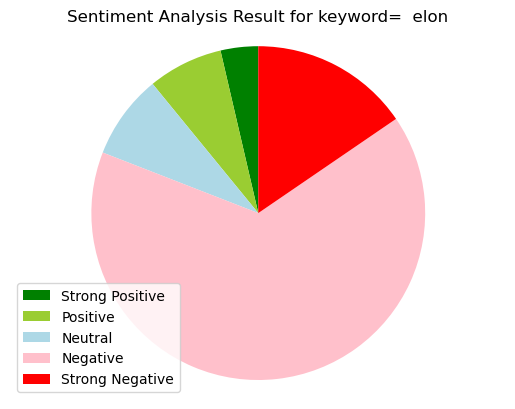

,index,author_id,created_at,edit_history_tweet_ids,id,lang,text,text_translated,textblob_sentiment,textblob_subjectivity,nltk_sentiment,flair_sentiment,polar_sentiment,score_class
0,405,342734944,2022-11-05 10:21:33+00:00,[1588838922653642752],1588838922653642752,en,@IAPonomarenko @elonmusk Elon needs to get bac...,@IAPonomarenko @elonmusk Elon needs to get bac...,0.250000,0.500000,0.1779,-1,-0.713950,negative
1,404,891438573102276610,2022-11-05 10:21:33+00:00,[1588838923253739525],1588838923253739525,et,RT @247AfricanFacts: African Countries with th...,RT @247AfricanFacts: African Countries with th...,0.000000,0.000000,0.0000,1,0.213950,positive
2,403,1206832634531373056,2022-11-05 10:21:33+00:00,[1588838923270512642],1588838923270512642,en,"RT @BitcoinMagazine: Elon Musk: ""They’re tryin...","RT @BitcoinMagazine: Elon Musk: ""They’re tryin...",0.200000,0.533333,0.8074,-1,-1.037033,strong negative
3,402,434413227,2022-11-05 10:21:33+00:00,[1588838924398780416],1588838924398780416,en,RT @BidenSuperfan1: Elon Musk turning off the ...,RT @BidenSuperfan1: Elon Musk turning off the ...,0.800000,0.700000,0.4215,-1,-1.310750,strong negative
4,401,1206445653594914818,2022-11-05 10:21:33+00:00,[1588838925388648448],1588838925388648448,es,RT @Girauters: Más de 2€ (el litro) de gasoil ...,RT @Girauters: More than €2 (a liter) of diese...,0.250000,0.250000,-0.1280,-1,-0.311000,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,94,1226580329206571008,2022-11-05 10:21:20+00:00,[1588838870413881344],1588838870413881344,de,Wer sich wegen Elon Musk über Twitter echauffi...,Anyone who gets angry about Elon Musk on Twitt...,-0.300000,0.525000,-0.5106,-1,-0.930300,negative
106,92,2840049453,2022-11-05 10:21:20+00:00,[1588838871512801280],1588838871512801280,es,RT @Kildames: Elon Musk tuvo una rabieta y com...,RT @Kildames: Elon Musk had a tantrum and boug...,0.166667,0.250000,-0.4215,-1,-0.377417,negative
107,91,1562466086150217728,2022-11-05 10:21:20+00:00,[1588838871823192065],1588838871823192065,en,RT @WaifuBSC: @cz_binance @elonmusk please buy...,RT @WaifuBSC: @cz_binance @elonmusk please buy...,-0.500000,1.000000,-0.0516,-1,-1.275800,strong negative
108,93,3246319053,2022-11-05 10:21:20+00:00,[1588838871449866243],1588838871449866243,es,RT @Kildames: Elon Musk tuvo una rabieta y com...,RT @Kildames: Elon Musk had a tantrum and boug...,0.166667,0.250000,-0.4215,-1,-0.377417,negative


In [ ]:
#Create piechart
strong_positive = len(df[df['score_class'] == 'strong positive'])
positive = len(df[df['score_class'] == 'positive'])
neutral = len(df[df['score_class'] == 'neutral'])
negative = len(df[df['score_class'] == 'negative'])
strong_negative = len(df[df['score_class'] == 'strong negative'])

#labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
labels = ['Strong Positive', 'Positive','Neutral','Negative','Strong Negative']
sizes = [strong_positive, positive, neutral, negative, strong_negative]
colors = ['green','yellowgreen','lightblue','pink','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis Result for keyword=  '+keyword+'')
plt.axis('equal')
plt.show()

df